<a href="https://colab.research.google.com/github/tawhidliyon/Machine-Learning/blob/main/Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os
import random
import time
from google.colab import drive

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Cell 2: Mount Google Drive for saving models (optional)
# Uncomment the following line to mount your Google Drive
# drive.mount('/content/drive')

# Create a directory to save models
os.makedirs('models', exist_ok=True)

In [3]:
# Cell 3: Download and preprocess CIFAR-10 data
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Download the CIFAR-10 dataset (will be cached after first download)
print("Downloading CIFAR-10 dataset...")
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create validation split
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 45000
Number of validation samples: 5000
Number of test samples: 10000
Number of training batches: 352
Number of validation batches: 40
Number of test batches: 79


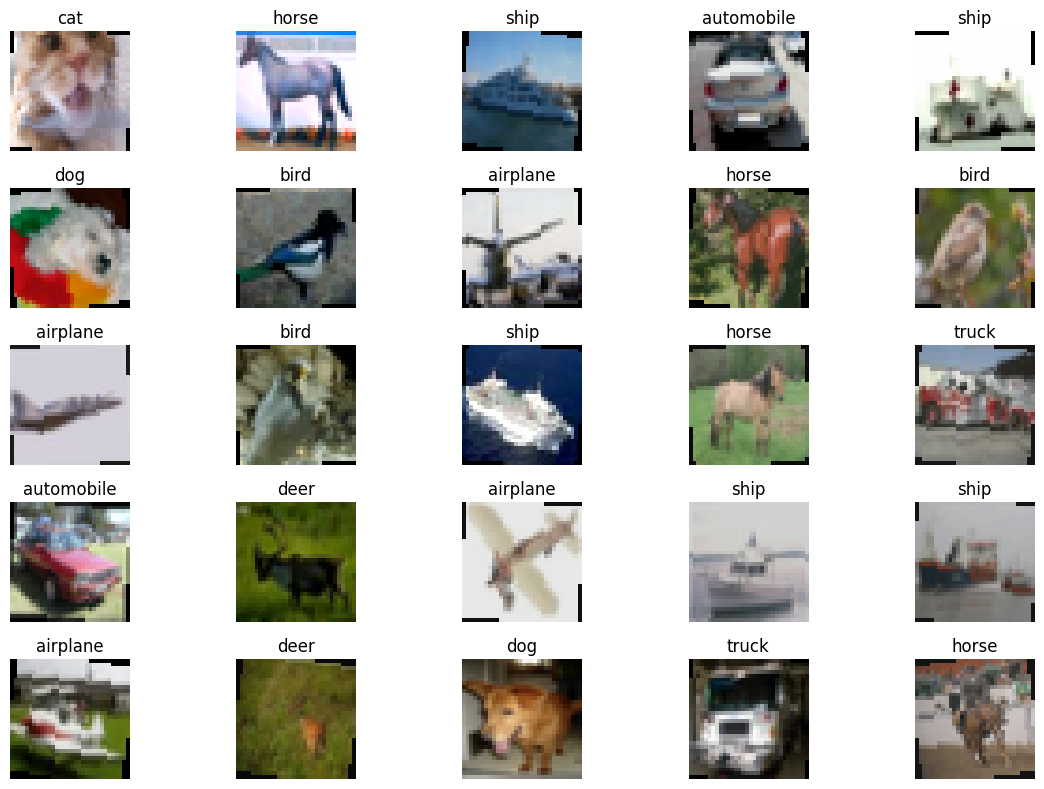

In [4]:
# Cell 4: Visualize sample images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images
plt.figure(figsize=(12, 8))
for i in range(25):
    if i < len(images):
        plt.subplot(5, 5, i+1)
        # Denormalize images for display
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()

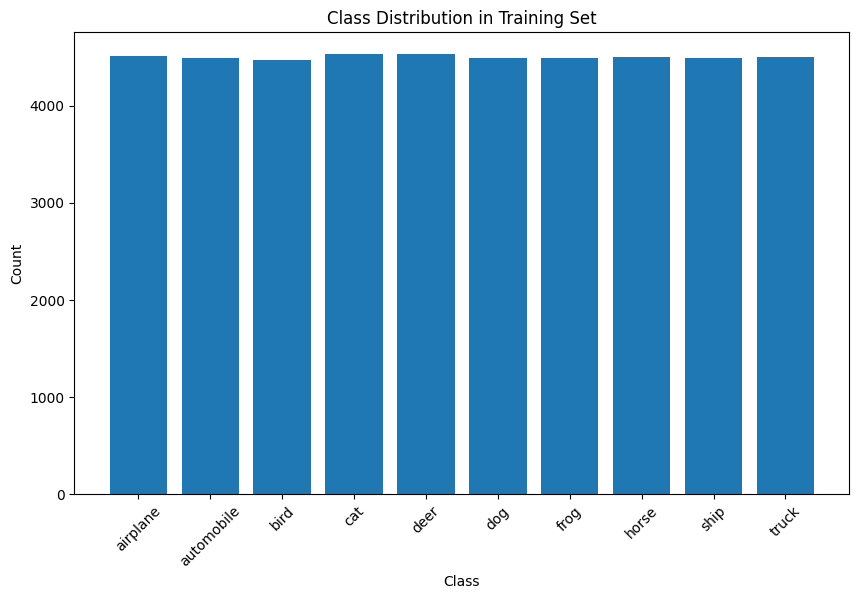

In [5]:
# Cell 5: Data distribution analysis
# Check class distribution in the training set
labels_count = [0] * 10
for _, label in train_dataset:
    labels_count[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(range(10), labels_count)
plt.xticks(range(10), class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
# Cell 6: Define CNN model architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CIFAR10Net(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10Net, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)

        # Pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# Initialize model
model = CIFAR10Net().to(device)
print(model)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

CIFAR10Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

In [7]:
# Cell 7: Define training functions
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc="Validating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [8]:
# Cell 8: Train the model
# Set up loss function, optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
num_epochs = 20  # You can reduce this if needed
best_valid_acc = 0.0
early_stop_counter = 0
early_stop_patience = 10

# Create history dictionary to store metrics
history = {
    'train_loss': [],
    'train_acc': [],
    'valid_loss': [],
    'valid_acc': [],
    'lr': []
}

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}")

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate after each epoch
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

    # Update learning rate based on validation loss
    scheduler.step(valid_loss)

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    history['lr'].append(current_lr)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    # Save best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'models/best_cifar10_model.pth')
        early_stop_counter = 0
        print(f"New best validation accuracy: {best_valid_acc:.4f} - Model saved!")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

    # Early stopping
    if early_stop_counter >= early_stop_patience:
        print("Early stopping!")
        break

training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_valid_acc:.4f}")

Starting training...

Epoch 1/20, LR: 0.001000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.4347, Train Acc: 0.4728
Valid Loss: 1.5689, Valid Acc: 0.5038
New best validation accuracy: 0.5038 - Model saved!

Epoch 2/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9920, Train Acc: 0.6475
Valid Loss: 1.1225, Valid Acc: 0.6116
New best validation accuracy: 0.6116 - Model saved!

Epoch 3/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8093, Train Acc: 0.7137
Valid Loss: 0.8577, Valid Acc: 0.7024
New best validation accuracy: 0.7024 - Model saved!

Epoch 4/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6843, Train Acc: 0.7605
Valid Loss: 0.6829, Valid Acc: 0.7578
New best validation accuracy: 0.7578 - Model saved!

Epoch 5/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6010, Train Acc: 0.7933
Valid Loss: 0.6885, Valid Acc: 0.7634
New best validation accuracy: 0.7634 - Model saved!

Epoch 6/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5417, Train Acc: 0.8116
Valid Loss: 0.5725, Valid Acc: 0.7960
New best validation accuracy: 0.7960 - Model saved!

Epoch 7/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4863, Train Acc: 0.8306
Valid Loss: 0.5509, Valid Acc: 0.8138
New best validation accuracy: 0.8138 - Model saved!

Epoch 8/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4454, Train Acc: 0.8457
Valid Loss: 0.4945, Valid Acc: 0.8238
New best validation accuracy: 0.8238 - Model saved!

Epoch 9/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4090, Train Acc: 0.8604
Valid Loss: 0.4600, Valid Acc: 0.8394
New best validation accuracy: 0.8394 - Model saved!

Epoch 10/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3815, Train Acc: 0.8688
Valid Loss: 0.4291, Valid Acc: 0.8548
New best validation accuracy: 0.8548 - Model saved!

Epoch 11/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3569, Train Acc: 0.8751
Valid Loss: 0.4238, Valid Acc: 0.8506
Early stopping counter: 1/10

Epoch 12/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3272, Train Acc: 0.8858
Valid Loss: 0.4556, Valid Acc: 0.8414
Early stopping counter: 2/10

Epoch 13/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3044, Train Acc: 0.8952
Valid Loss: 0.5813, Valid Acc: 0.8152
Early stopping counter: 3/10

Epoch 14/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2849, Train Acc: 0.9011
Valid Loss: 0.4159, Valid Acc: 0.8600
New best validation accuracy: 0.8600 - Model saved!

Epoch 15/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2703, Train Acc: 0.9051
Valid Loss: 0.4369, Valid Acc: 0.8494
Early stopping counter: 1/10

Epoch 16/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2458, Train Acc: 0.9132
Valid Loss: 0.3993, Valid Acc: 0.8698
New best validation accuracy: 0.8698 - Model saved!

Epoch 17/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2342, Train Acc: 0.9176
Valid Loss: 0.4337, Valid Acc: 0.8568
Early stopping counter: 1/10

Epoch 18/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2187, Train Acc: 0.9242
Valid Loss: 0.4009, Valid Acc: 0.8684
Early stopping counter: 2/10

Epoch 19/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.2007, Train Acc: 0.9295
Valid Loss: 0.4409, Valid Acc: 0.8560
Early stopping counter: 3/10

Epoch 20/20, LR: 0.001000


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.1906, Train Acc: 0.9332
Valid Loss: 0.3815, Valid Acc: 0.8812
New best validation accuracy: 0.8812 - Model saved!
Training completed in 13.51 minutes
Best validation accuracy: 0.8812


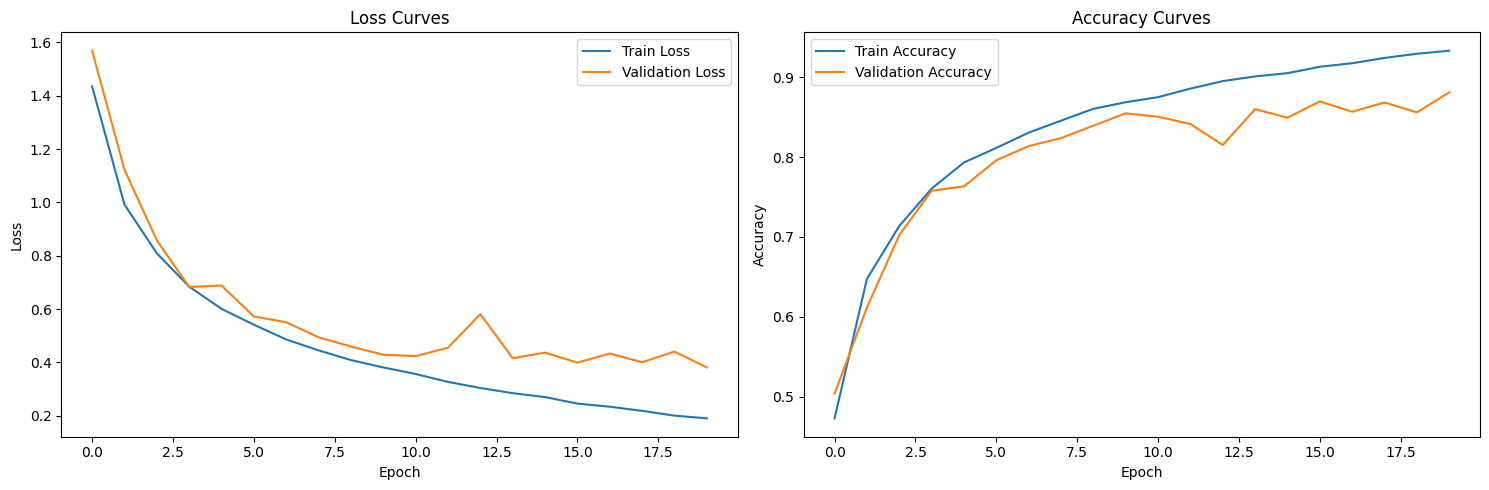

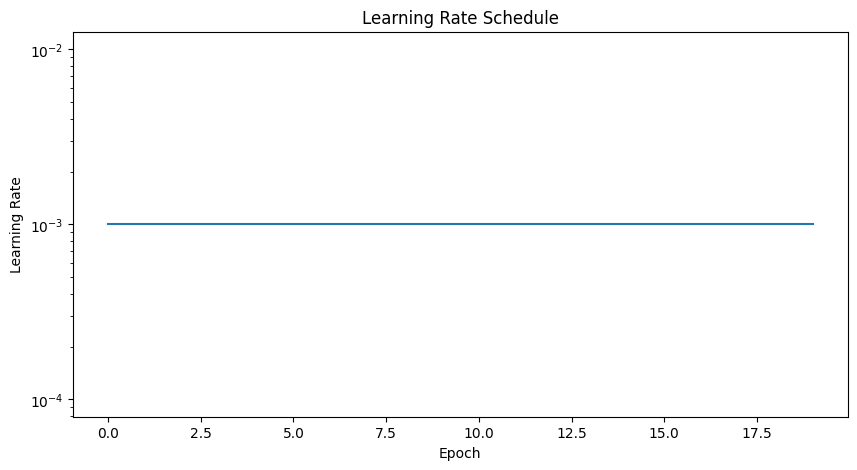

In [9]:
# Cell 9: Plot training curves
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot learning rate
plt.figure(figsize=(10, 5))
plt.plot(history['lr'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.show()


In [10]:
# Cell 10: Evaluate on test set
# Load best model
model.load_state_dict(torch.load('models/best_cifar10_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

<ipython-input-10-8f221991141d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_cifar10_model.pth'))


Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3352, Test Accuracy: 0.8924


Getting predictions:   0%|          | 0/79 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.90      0.89      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.85      0.84      0.85      1000
         cat       0.78      0.78      0.78      1000
        deer       0.92      0.87      0.89      1000
         dog       0.82      0.85      0.84      1000
        frog       0.92      0.93      0.93      1000
       horse       0.93      0.91      0.92      1000
        ship       0.93      0.95      0.94      1000
       truck       0.93      0.94      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



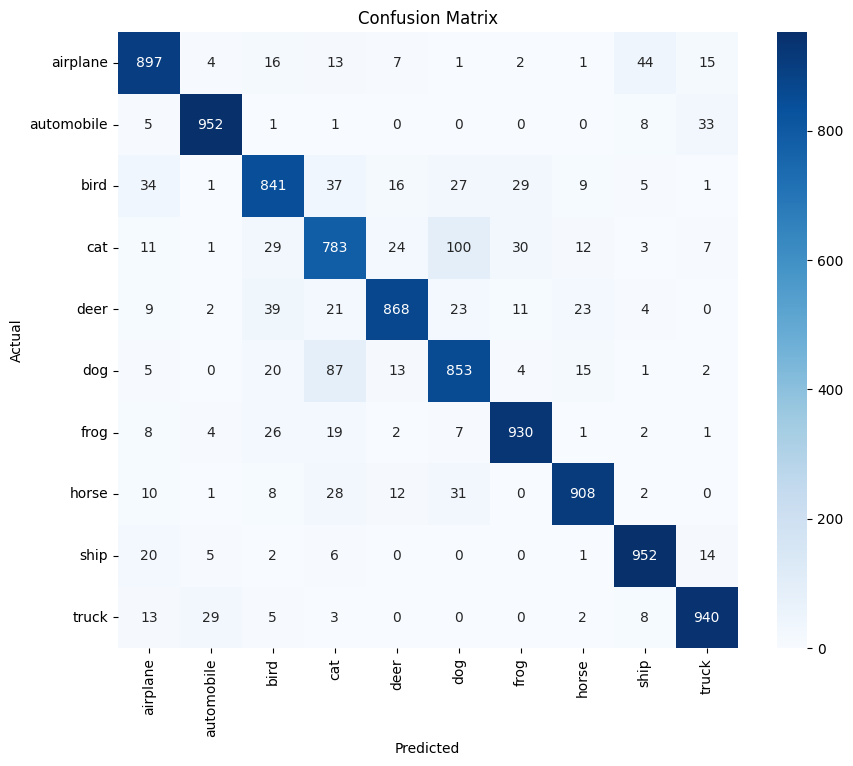

In [11]:
# Cell 11: Detailed evaluation
# Get predictions and actual labels
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Getting predictions"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

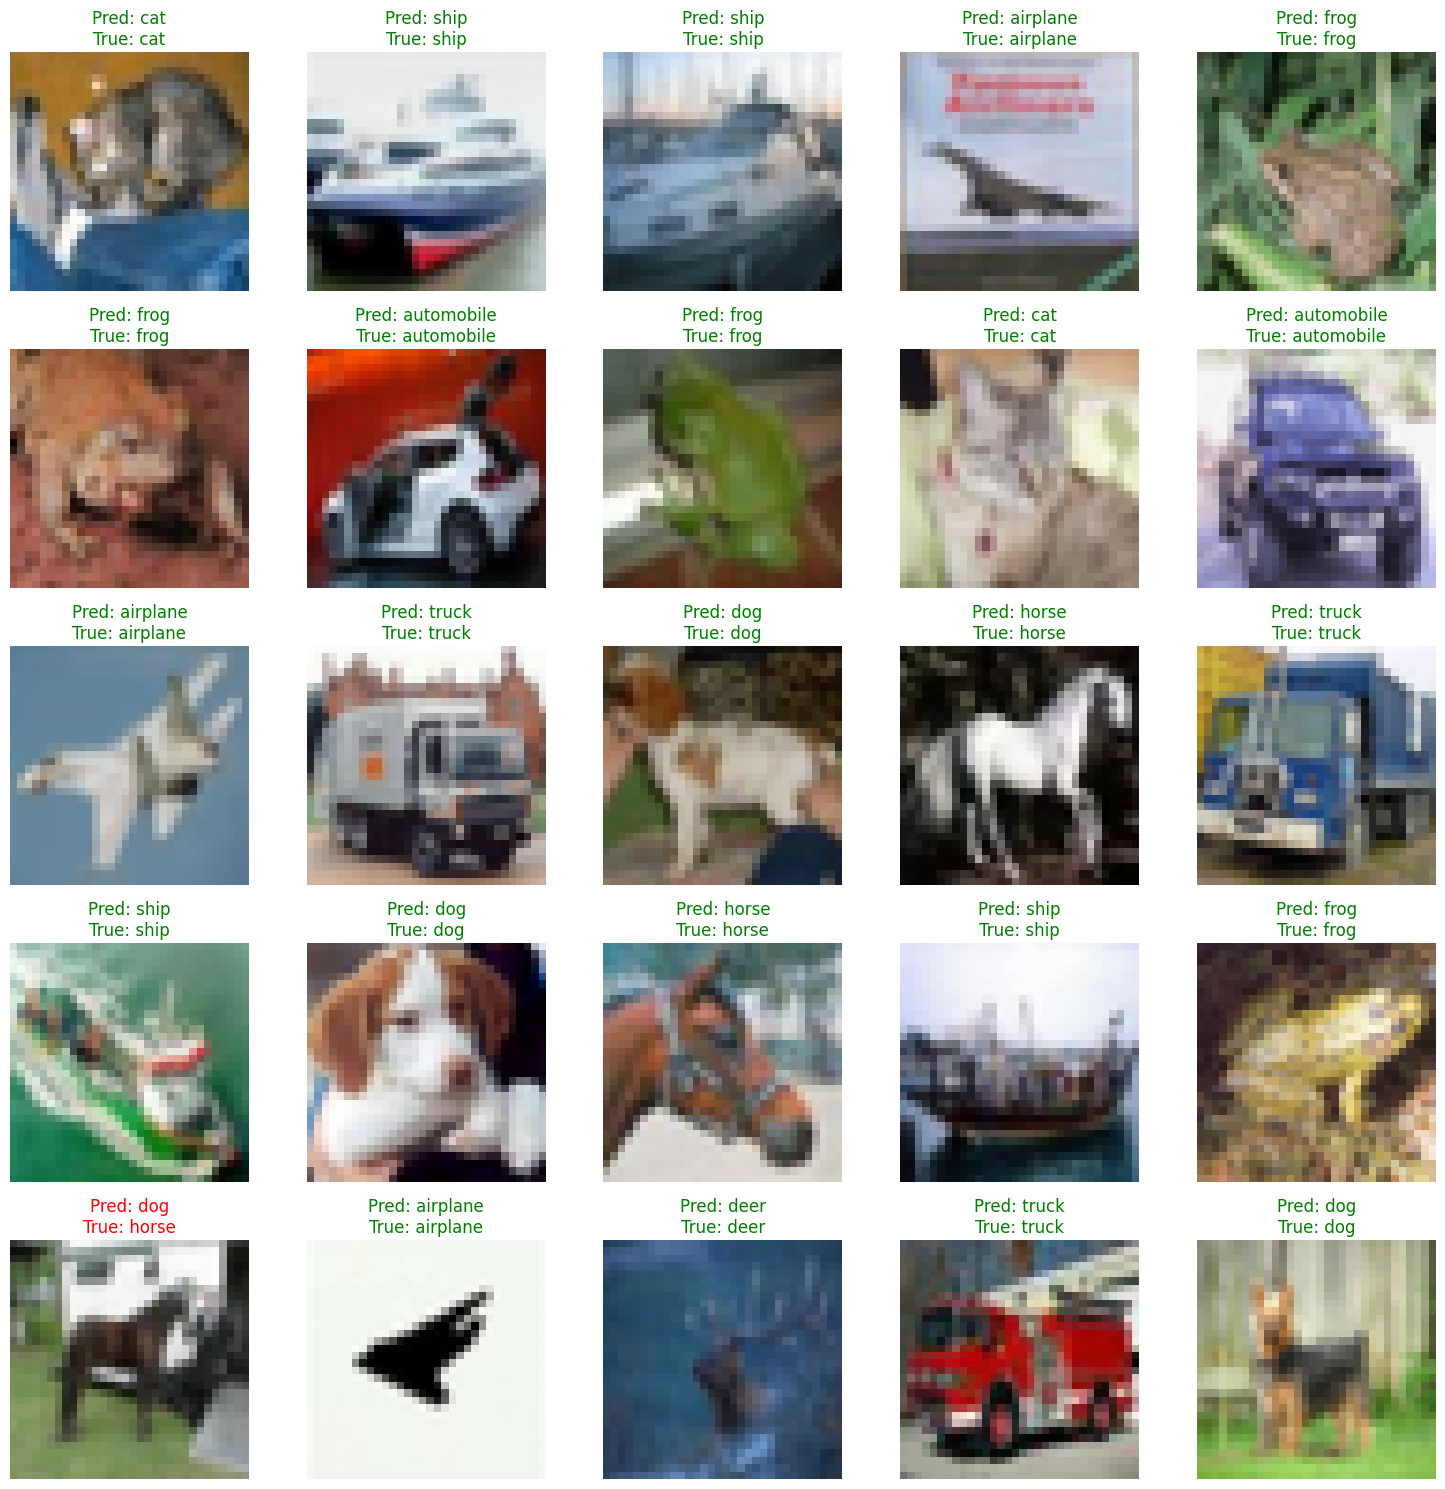

In [12]:
# Cell 12: Visualize model predictions
def display_predictions(model, test_loader, class_names, num_images=25, device=device):
    model.eval()

    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    # Convert back to numpy for visualization
    images_np = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot the images
    fig = plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)

        # Denormalize images for display
        img = images_np[i].transpose(1, 2, 0)
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display predictions
display_predictions(model, test_loader, class_names)

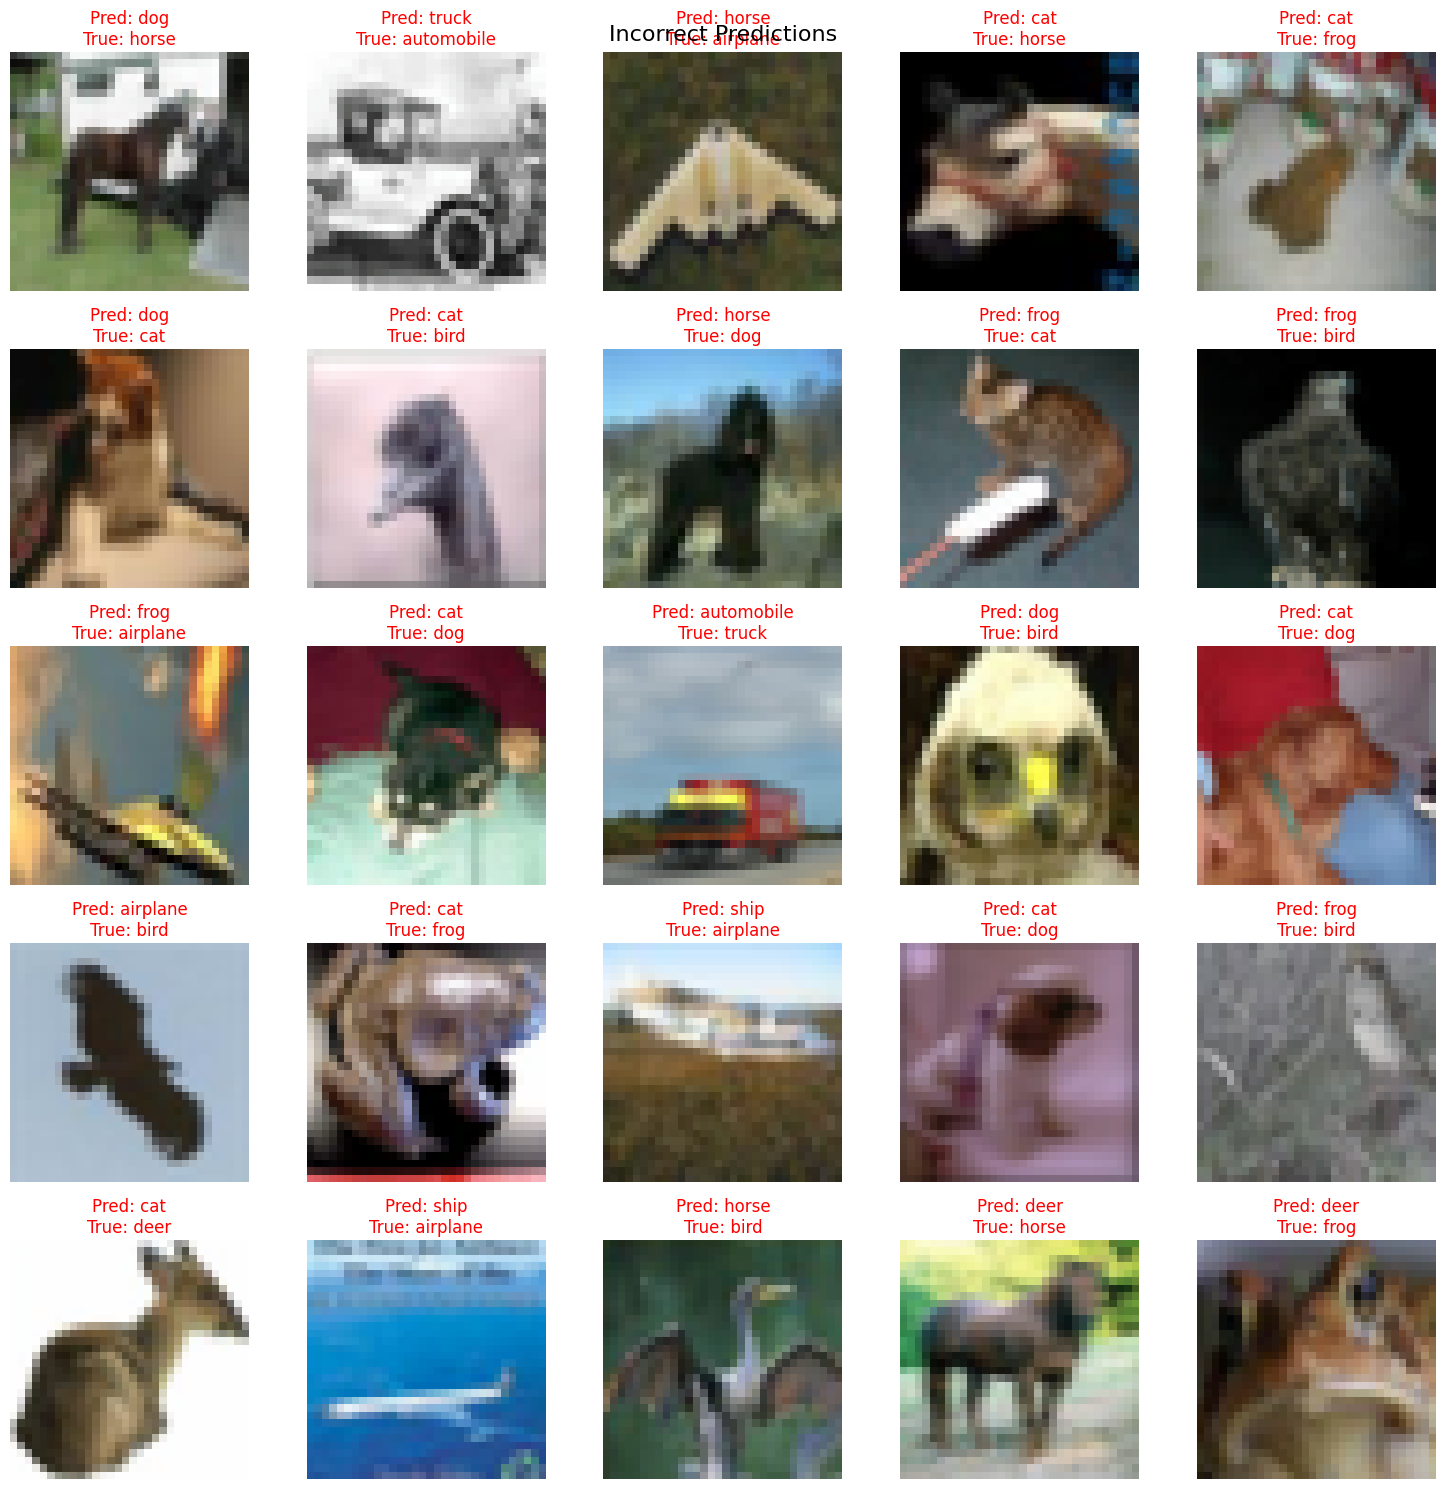

In [13]:
# Cell 13: Model visualization - incorrect predictions
def display_incorrect_predictions(model, test_loader, class_names, num_images=25, device=device):
    model.eval()

    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Find incorrect predictions
            incorrect_mask = preds != labels

            if incorrect_mask.any():
                incorrect_idx = torch.where(incorrect_mask)[0]
                incorrect_images.append(images[incorrect_idx].cpu())
                incorrect_labels.append(labels[incorrect_idx].cpu())
                incorrect_preds.append(preds[incorrect_idx].cpu())

            if sum(len(x) for x in incorrect_images) >= num_images:
                break

    # Convert to tensors
    incorrect_images = torch.cat(incorrect_images)[:num_images]
    incorrect_labels = torch.cat(incorrect_labels)[:num_images]
    incorrect_preds = torch.cat(incorrect_preds)[:num_images]

    # Convert to numpy for visualization
    images_np = incorrect_images.cpu().numpy()
    labels = incorrect_labels.cpu().numpy()
    preds = incorrect_preds.cpu().numpy()

    # Plot the images
    fig = plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images_np))):
        plt.subplot(5, 5, i+1)

        # Denormalize images for display
        img = images_np[i].transpose(1, 2, 0)
        img = img * np.array([0.2470, 0.2435, 0.2616]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Incorrect Predictions", fontsize=16)
    plt.show()

# Display incorrect predictions
display_incorrect_predictions(model, test_loader, class_names)

In [14]:
# Cell 14: Export model for submission to Kaggle
def prepare_submission(model, test_loader, output_file="submission.csv", device=device):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc="Generating predictions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())

    # Create submission dataframe
    submission = pd.DataFrame({
        'id': range(1, len(all_preds) + 1),
        'label': all_preds
    })

    # Save to csv
    submission.to_csv(output_file, index=False)
    print(f"Submission file created: {output_file}")

    # If Google Drive is mounted, also save there
    if os.path.exists('/content/drive/My Drive'):
        drive_path = '/content/drive/My Drive/cifar10_submission.csv'
        submission.to_csv(drive_path, index=False)
        print(f"Submission file also saved to Google Drive: {drive_path}")

    return submission

# Generate submission file
submission = prepare_submission(model, test_loader, 'models/submission.csv')
submission.head()

Generating predictions:   0%|          | 0/79 [00:00<?, ?it/s]

Submission file created: models/submission.csv


,id,label
0,1,3
1,2,8
2,3,8
3,4,0
4,5,6


In [15]:
# Cell 15: Summary and Final Model Performance
print("CIFAR-10 Classification Project Summary")
print("=======================================")
print(f"Model Architecture: ResNet-inspired CNN")
print(f"Total Parameters: {trainable_params:,}")
print(f"Training Time: {training_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Learning Rate Schedule: ReduceLROnPlateau")
print(f"Data Augmentation: Horizontal flips, rotations, color jitter")
print(f"Regularization: Dropout, BatchNorm, Weight decay")
print(f"Optimizer: AdamW")
print("=======================================")

CIFAR-10 Classification Project Summary
Model Architecture: ResNet-inspired CNN
Total Parameters: 2,777,674
Training Time: 13.51 minutes
Best Validation Accuracy: 0.8812
Final Test Accuracy: 0.8924
Learning Rate Schedule: ReduceLROnPlateau
Data Augmentation: Horizontal flips, rotations, color jitter
Regularization: Dropout, BatchNorm, Weight decay
Optimizer: AdamW
